# Visualisation as a tool for network introspection

In this tutorial we will learn how to visualise a trained model. Step-by-step, we are going to: 

1) Explore the filter structure of a trained network used for scientific applications

2) Compare filter structures and develop strategies to get meaningful results

3) Visualise activation, or feature maps

### Data and trained network model
The data are simulated astrophysical 3D lightcones of the 21cm signal of the forbidden spin-flip transition of neutral hydrogen, generated with the semi-numerical code 21cmFAST (https://github.com/21cmfast/21cmFAST), in the case of mock lightcones noise was generated with the code 21cmSense (https://github.com/jpober/21cmSense), to represent data as expected for the Square Kilometre Array at radio wavelengths. The trained network model is the 3D-21cmPIE-Net (see https://github.com/stef-neu/3D-21cmPIE-Net) as published in Neutsch, Heneka, Brueggen 2022 (arXiv:2201.07587). Credit of the code go to Steffen Neutsch, Caroline Heneka 2022. 

### General remarks
As we use trained models for this task, GPU are not necessarily required.

In [1]:
# some packages that we will need
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
# !pip install tf-keras-vis tensorflow

# from google.colab import drive
# drive.mount('/content/gdrive')

# !wget https://github.com/csheneka/introspection-tutorial/blob/main/models/3D_21cmPIE_Net_optmock_par6.h5
# !wget https://github.com/csheneka/introspection-tutorial/blob/main/models/3D_21cmPIE_Net_sim_par6.h5

2.9.1


In [2]:
# optional color-scheme for plotting later on
from matplotlib import colors
eor_colour = colors.LinearSegmentedColormap.from_list(
    "EoR",
    [
        (0, "white"),
        (0.21, "yellow"),
        (0.42, "orange"),
        (0.63, "red"),
        (0.86, "black"),
        (0.9, "blue"),
        (1, "cyan"),
    ],
)
plt.register_cmap(cmap=eor_colour)

## 1) Load a trained model and explore its filter structure

The trained model is available both trained on simulations-only and on mock data including noise.

### Question 1: 
What do you notice about the trained model(s)? How is the structure of the model, what is the architecture? How many filters are there to visualise in every layer?

### Task 1: 
Explore plotting the filters of the first layer, how do they look, what might they do?

In [3]:
# Load the trained model(s)
# model 1 simulations-only: models/3D_21cmPIE_Net_sim_par6.h5
# model 2 mock: models/3D_21cmPIE_Net_optmock_par6.h5
model = keras.models.load_model('3D_21cmPIE_Net_sim_par6.h5')

model.summary()

# Also: You can re-do (all) tasks with the model trained on mock data ('3D_21cmPIE_Net_optmock_par6.h5') and compare

Model: "littleTimmy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 140, 2350,   0         
                             1)]                                 
                                                                 
 conv3d (Conv3D)             (None, 138, 138, 23, 32)  29408     
                                                                 
 conv3d_1 (Conv3D)           (None, 136, 136, 22, 32)  18464     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 68, 68, 22, 32)   0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 66, 66, 21, 64)    36928     
                                                                 
 zero_padding3d (ZeroPadding  (None, 68, 68, 21, 64)   

2022-08-10 18:34:21.289842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


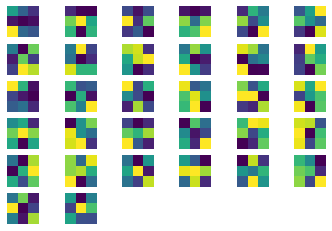

In [4]:
# Task 1: We have a look at the non-averaged filters, e.g. the spatial 2D part of the filters
# Tipp: check first what is the kernel shape for the layer of interest

nfilter = 32
nplots = nfilter
zpix = 0
n_axis = 6
for i in range(nplots):
    weights = model.layers[1].weights[0].numpy()
    # print(weights.shape)
    weights = weights.reshape(3,3,102,nfilter)[:,:,:,i]
    plt.subplot(n_axis, n_axis, 1 + i)
    plt.axis('off')
    xy = plt.imshow(weights[:,:,zpix],cmap="viridis")
    # plt.colorbar(xy)

## 2) Compare filter structures and develop strategies to get meaningful results

### Question 2: 
Could we do something with the filters, knowing the variation in 2D (spatial) is very different from the +1D temporal dimension?

### Task 2: 
Plot each of the nfilters from the first convolutional layer averaged over spatial dimensions. What do you see?

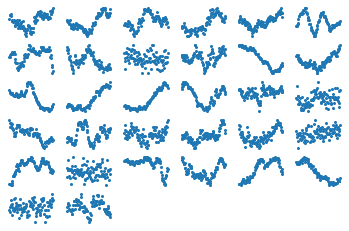

In [5]:
# Task 2: Spatially average and plot filters
nfilter = 32
nplots = nfilter
n_axis = 6
for i in range(nplots):
    weights = model.layers[1].weights[0].numpy()
    weights = weights.reshape(3,3,102,nfilter)[:,:,:,i]
    weights = np.mean(weights,axis=(0,1)) # spatial dims
    x = np.linspace(0,len(weights),len(weights))
    plt.subplot( n_axis, n_axis, 1 + i )
    plt.scatter(x,weights,s=4)
    plt.axis('off')

## 3) Visualise activation, or feature maps
### 3a) Load data from Sample File with (21cm) lighcones at radio wavelengths

### Task 3a: 
Load and plot 3D lightcone data. Explore spatial and temporal structure. 

In [6]:
# Read light-cones from tfrecords files
# to simplify things, we use knowledge on the data shape and input features for parsing
HII_DIM=140
BOX_LEN=2350
nlabel = 6
nz = 92
def parse_function(files):
    keys_to_features = {"label":tf.io.FixedLenFeature((nlabel),tf.float32),
                        "image":tf.io.FixedLenFeature((),tf.string),
                        "tau":tf.io.FixedLenFeature((),tf.float32),
                        "gxH":tf.io.FixedLenFeature((nz),tf.float32),
                        "z":tf.io.FixedLenFeature((nz),tf.float32),}
    parsed_features = tf.io.parse_example(files, keys_to_features)
    image = tf.io.decode_raw(parsed_features["image"],tf.float16)
    image = tf.reshape(image,(HII_DIM,HII_DIM,BOX_LEN))
    return image, parsed_features["label"] # Image, label ordering: m_WDM,Omega_m,L_X,E_0,T_vir,zeta

data_file="data/lc1n.tfrecord"
dataset = tf.data.TFRecordDataset(data_file)
dataset = dataset.map(parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = np.array(list(dataset.as_numpy_iterator()),dtype=object)
print(data.shape)
print(data[0,0].shape)

(10, 2)
(140, 140, 2350)


lighcones in dataset:  10


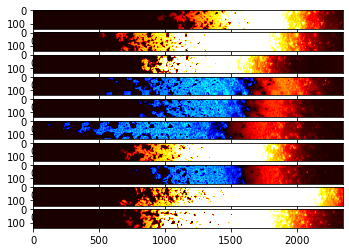

In [7]:
# plot lightcone slices
N_lcs = data.shape[0]
print('lighcones in dataset: ',N_lcs)
no_lc = 9
nslice = 139

for i in range(N_lcs):
    lc = data[i,0]
    lc_slice = lc[nslice,:,:]
    plt.subplot(N_lcs, 1, 1 + i)    
    xy = plt.imshow(lc_slice,cmap="EoR",vmin=-150,vmax=30)
    # plt.colorbar(xy,orientation="horizontal",aspect=40)
    
# bonus: for light-cones and activations you can make e.g. impressive-looking gifs of moving through the 3D data

### Task 3b: 
Plot the activation or feature maps after the first layer for an example lightcone.
### Question 3: 
How do the activations look like in the first layer? How later on? What do they tell?

(1, 138, 138, 23, 32)


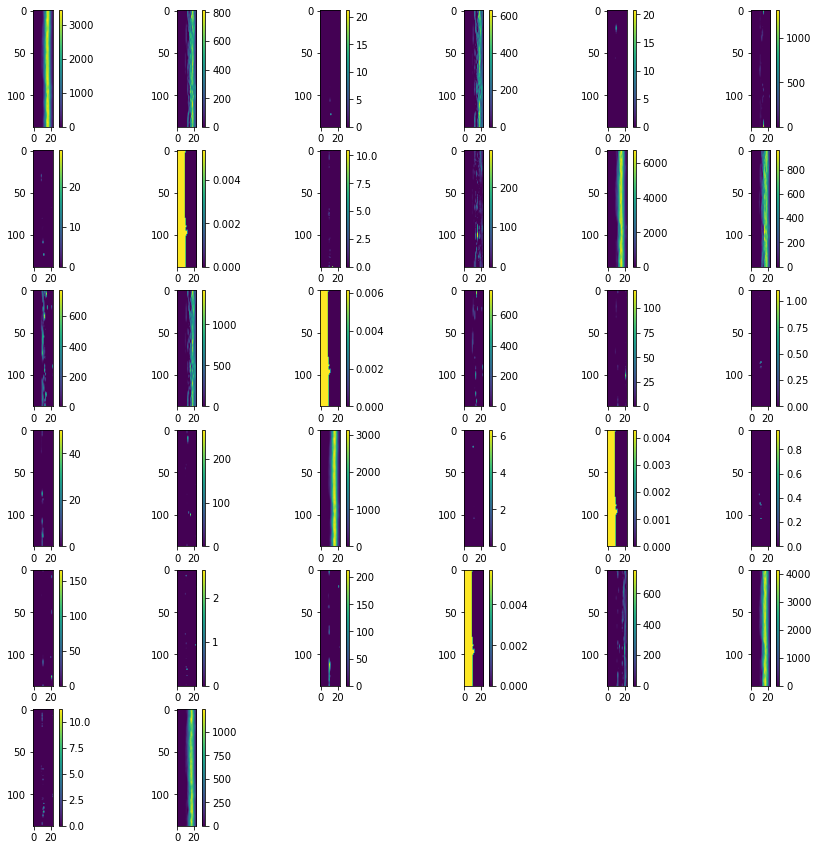

In [8]:
# plot the activation, or features
nslice = 1
nfilter = 32

lc_predict = data[0,0]
img_tensor = np.expand_dims(lc_predict, axis=0)

# get the activation for example after the first layer
activation_model = keras.Model(inputs=model.inputs, outputs=model.layers[1].output)
activation = activation_model(img_tensor)
print(activation.shape)

plt.figure(figsize=(15,15))
for i in range(32):
    plt.subplot(6,6,i+1)
    feature_map = activation[0,nslice,:,:,i]   
    xy = plt.imshow(feature_map)
    plt.colorbar(xy,orientation="vertical",aspect=40)
    
# alternate approach: 
# directly multiply and scan the data with the filters to see the effect of convolution with the kernel 'in action'